In [1]:
#The purpose of this script is to parse the raw clipper output to clusters for analysis as well
#as the RT stops to use
#NOTE - this script uses the file used to make the bam file for clipper. need to find the original file used to make the bam file

#the first part of this script uses the original clipper output and just uses it for normalized comparison. We will also bring in the gene expression normalization and plotting

#the second half of this script begins to use the functions from FAST-iCLIP to isolate individual RT stops from CLIPPER. There are some problems with this including duplicates and a mismatch between total clipper reads and RT stop reads in the clipper window
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)



/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def makeClusterCenter(windowsFile):
	# Usage: Generate a file of cluster centers.
	# Input: Raw CLIPper output file.
	# Output: File with coordinates for the center of each CLIPper cluster.
	cleanBed = cleanBedFile(windowsFile)
	centers=cleanBed.replace('.bed','.clusterCenter')
	f = open(centers, 'w')
	with open(cleanBed, 'r') as infile:
		for line in infile:
			elementList = line.strip().split('\t')
			diff=abs(int((int(elementList[1])-int(elementList[2]))/2))
			f.write(elementList[0]+'\t'+str(int(elementList[1])+diff)+'\t'+str(int(elementList[1])+diff+1)+'\n')
	f.close()
	return centers

In [3]:
%%time
#get the clipper data and move it to a format that works
#Remember - the _dupl means that there are some duplicates remaining from hitting multiple genes in the clipper annotation
#delete the apex, clean up the gene, keep everything else
#also flip the order so that counts is at the end
#DMSO - as a column of 0's to the end
clipper_file = open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    strand = line[5]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,strand)
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.append(0)
    #add a random 0 score into index 4 to put the strand in the proper location in index 5
    line.insert(4,0)
    clipper_list.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

#TAM - add a column of 0's before the score
clipper_file = open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    strand = line[5]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,strand)
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.insert(5,0)
    #add a random 0 score into index 4 to put the strand in the proper location in index 5
    line.insert(4,0)
    clipper_list.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

CPU times: user 4.64 s, sys: 192 ms, total: 4.83 s
Wall time: 5.74 s


In [4]:
#need to write a function to fix the bedtools stranded merge each time
def reset_after_bedtools_merge(merged_file_path):
    """This will take the 4th column of a bedtools stranded merge and move it to the 6th column so that another merge can be completed"""
    temp_list = []
    with open(merged_file_path) as f:
        for line in f:
            line = line.strip().split('\t')
            strand = line[3]
            line.insert(6,strand)
            del line[3]
            temp_list.append(line)
    with open(merged_file_path,'w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(temp_list)    

In [5]:
#need to keep bedtools v2.25.0
!bedtools --version

bedtools v2.25.0


In [6]:
%%time
###PROBLEM - WE ARE NOT MERGING BY STRAND SO THERE ARE A FEW OVERLAPS BY STRAND
#How many clusters are we losing? This is pretty minimal - should I consider these. To do this I need to reformat so that strand is in column 6.
#DMSO = 9
#TAM = 15
#NOTE - I FIXED THIS BY USING BEDTOOLS 2.25.0 STRANDED MERGE, but the output puts the merge in the 4th column
#STRAND OUTPUT SHOULD BE CORRECT

###PROBLEM - WE ARE OVERLAPPING GENES. HOW MANY CLUSTERS ARE WE LOSING DUE TO OVERLAPPING GENES
#DMSO = 22754
#TAM = 19650

#This is a problem - I need to pull out the ones separated by strand and have separate entries for them. Do I associated them by different clusters?


#Merge the clipper clusters together to deal with duplicates
#Prevent bookended clusters from merging together with -d -1
#Now count the number of commas in the gene column and divide the 5th column by 3
#DMSO
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,7,8 -o distinct,distinct,sum,sum -d -1 -s > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
reset_after_bedtools_merge('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged')
inlist = []
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = float(line[3].count(',')+1)
            corrected_read_count = float(line[6])/count
            line[6]=corrected_read_count
        inlist.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

#TAM
!bedtools merge -i hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,7,8 -o distinct,distinct,sum,sum -d -1 -s > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
reset_after_bedtools_merge('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged')
inlist = []
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = float(line[3].count(',')+1)
            corrected_read_count = float(line[7])/count
            line[7]=corrected_read_count
        inlist.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

CPU times: user 5.18 s, sys: 924 ms, total: 6.11 s
Wall time: 10.3 s


                       start       end  blank  hnM_DMSO   hnM_TAM  hnM_DMSO_1  \
start               1.000000  1.000000    NaN -0.001846 -0.001629   -0.001846   
end                 1.000000  1.000000    NaN -0.001846 -0.001629   -0.001846   
blank                    NaN       NaN    NaN       NaN       NaN         NaN   
hnM_DMSO           -0.001846 -0.001846    NaN  1.000000  0.922804    1.000000   
hnM_TAM            -0.001629 -0.001629    NaN  0.922804  1.000000    0.922804   
hnM_DMSO_1         -0.001846 -0.001846    NaN  1.000000  0.922804    1.000000   
hnM_TAM_1          -0.001629 -0.001629    NaN  0.922804  1.000000    0.922804   
log2ratio_TAM-DMSO  0.016932  0.016932    NaN -0.012942  0.013040   -0.012942   

                    hnM_TAM_1  log2ratio_TAM-DMSO  
start               -0.001629            0.016932  
end                 -0.001629            0.016932  
blank                     NaN                 NaN  
hnM_DMSO             0.922804           -0.012942  
hnM_TAM   

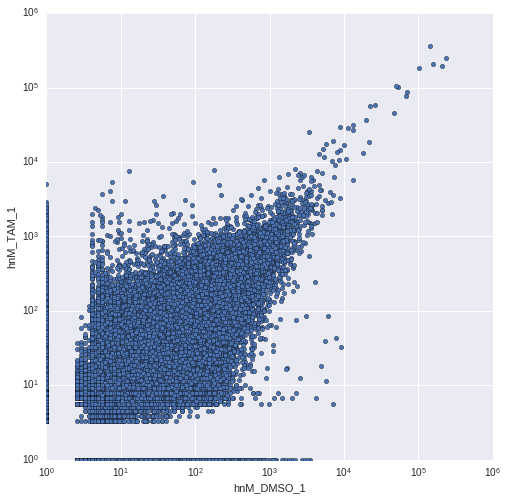

In [7]:
# %%time
#NOTE - I am using the best clipper output so far using the yeo lab parameters

#The purpose of this is to write a script to generate normalized reads in each sample based on total library size
#and then print this out to a normalized file

#Then the script will overlap the RT stops within a user defined region (i.e.50 bp) to generate clusters of RT stops

#Also the script will plot the normalized data 

#Then load these files into dataframes
DMSO_df = pd.read_csv('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','blank','strand','reads_dmso','reads_tam'])
TAM_df = pd.read_csv('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','blank','strand','reads_dmso','reads_tam'])
#now calculate and store the total number of RT stops as a scalar to divide by and then multiply
#DMSO
total_reads = DMSO_df.reads_dmso.sum()
DMSO_df.reads_dmso = DMSO_df.reads_dmso.mul(1e7/total_reads)
#TAM
total_reads = TAM_df.reads_tam.sum()
TAM_df.reads_tam = TAM_df.reads_tam.mul(1e7/total_reads)

#save the dataframes as beds
df_list = [DMSO_df,TAM_df]
file_names = ['hnM_DMSO','hnM_TAM']
counter = 0
for df in df_list:
    df.to_csv(file_names[counter]+'_normalized.bed',sep='\t',index = False,header = False)
    counter += 1

#now merge together into new clusters based on 20 nucleotides (This is what the Black RbFox paper did)
#PROBLEM - NOT COMBINING THE DATA CORRECTLY... there are clusters associated with multiple strands and multiple genes. The multiple strands is definitely a problem

!bedtools merge -i hnM_DMSO_normalized.bed -d 20 -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_DMSO_normalized_merge.bed
!bedtools merge -i hnM_TAM_normalized.bed -d 20 -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_TAM_normalized_merge.bed

#now overlap the different samples. Black Rbfox paper took intersecting clusters and compared the read count between only those that intersected. There was no information about the clusters that did not intersect. 

#now I need to merge the DMSO and TAM merged clusters so that I can have a common set of clusters
#To do this, concat together the merges and then remerge but do not have a d
#NOTE THIS ONLY WORKS WITH BEDTOOLS VERSION 2.25.0
reset_after_bedtools_merge('hnM_DMSO_normalized_merge.bed')
reset_after_bedtools_merge('hnM_TAM_normalized_merge.bed')
!cat hnM_DMSO_normalized_merge.bed hnM_TAM_normalized_merge.bed > hnM_DMSO_TAM.bed
!bedtools sort -i hnM_DMSO_TAM.bed > hnM_DMSO_TAM_sorted.bed
!bedtools merge -i hnM_DMSO_TAM_sorted.bed -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_DMSO_TAM_sorted_merged.bed
reset_after_bedtools_merge('hnM_DMSO_TAM_sorted_merged.bed')

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#Plot in Matplotlib and compute pearson correlation coefficient
ax = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,\
                                 xlim=(1,10e5),ylim=(1,10e5))

#compute pearson correlation between each column
print(hnM_DMSO_TAM_final_union_df.corr())

In [8]:
%%time
#get the gene expression file ready

#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0_fpkm','twist_d14_fpkm'])

#add a row with twist_d0_d14_fpkm_sum
twist_gene_exp_df['twist_d0_d14_fpkm_sum'] = twist_gene_exp_df.apply(lambda row: row['twist_d0_fpkm']+row['twist_d14_fpkm'],axis=1)

#we want to calculate TPM
#Equation from Harold Pimentel's blog: exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
#Do I need to add a psuedocount here?
twist_d0_fpkm_sum = twist_gene_exp_df.twist_d0_fpkm.sum()
twist_d14_fpkm_sum = twist_gene_exp_df.twist_d14_fpkm.sum()
twist_gene_exp_df['twist_d0_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d0_fpkm']+1)-np.log(twist_d0_fpkm_sum) + np.log(1e6)),axis=1)
twist_gene_exp_df['twist_d14_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d14_fpkm']+1)-np.log(twist_d14_fpkm_sum) + np.log(1e6)),axis=1)


#add in the length of the gene as calulated by cufflinks

twist_gene_exp_df['chr'] = twist_gene_exp_df['gene_coords'].str.split(':').str[0]
twist_gene_exp_df['coords'] = twist_gene_exp_df['gene_coords'].str.split(':').str[1]
twist_gene_exp_df['gene_length'] = twist_gene_exp_df['coords'].str.split('-').str[1].astype(int) - twist_gene_exp_df['coords'].str.split('-').str[0].astype(int)

# .str[1].split('-').str[1].astype(int) - twist_gene_exp_df['gene_coords'].str.split(':').str[1].split('-').str[0].astype(int)

#Try plotting the fpkm distribution in each of these - I did this in cummerbund in R

#also bring in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
twist_gene_exp_df = pd.merge(twist_gene_exp_df,gene_name_and_biotype_df,on='ens_gene',how='left')
#save this entity in the GO_analysis_folder
twist_gene_exp_df.to_csv('GO_analysis/complete_twist_gene_expression_dataframe',sep='\t',index=False,na_rep='NaN')

#collect a dictionary with ens_gene and length for use later. Name gene_and_length_dict
gene_and_length = twist_gene_exp_df[['ens_gene','gene_length']]
gene_and_length.to_csv('ens_gene_and_length',sep='\t',index=False,header=False)
gene_and_length_dict = {}
with open('ens_gene_and_length') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_length_dict[line[0]] = line[1]
        
#collect a dictionary with ens_gene and summed expression in both cells
gene_and_fpkm_sum = twist_gene_exp_df[['ens_gene','twist_d0_d14_fpkm_sum']]
gene_and_fpkm_sum.to_csv('ens_gene_and_fpkm_sum',sep='\t',index=False,header=False)
gene_and_fpkm_sum_dict = {}
with open('ens_gene_and_fpkm_sum') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_fpkm_sum_dict[line[0]] = float(line[1])


CPU times: user 4.68 s, sys: 68 ms, total: 4.74 s
Wall time: 5.01 s


In [9]:
twist_gene_exp_df.head()

,ens_gene,gene,gene_coords,twist_d0_fpkm,twist_d14_fpkm,twist_d0_d14_fpkm_sum,twist_d0_tpm,twist_d14_tpm,chr,coords,gene_length,external_gene_name,biotype
0,ENSG00000000003,TSPAN6,chrX:99883666-99894988,7.80703,7.20490,15.01193,15.471555,11.933714,chrX,99883666-99894988,11322,TSPAN6,protein_coding
1,ENSG00000000005,TNMD,chrX:99839798-99854882,0.00000,0.00000,0.00000,1.756728,1.454462,chrX,99839798-99854882,15084,TNMD,protein_coding
2,ENSG00000000419,DPM1,chr20:49505452-49575092,21.24340,12.94020,34.18360,39.075600,20.275490,chr20,49505452-49575092,69640,DPM1,protein_coding
3,ENSG00000000457,SCYL3,chr1:169631244-169863408,1.26274,1.07149,2.33423,3.975018,3.012903,chr1,169631244-169863408,232164,SCYL3,protein_coding
4,ENSG00000000460,C1orf112,chr1:169631244-169863408,2.70073,3.00648,5.70721,6.501175,5.827272,chr1,169631244-169863408,232164,C1orf112,protein_coding


In [10]:
%%time
#PROBLEM - now I need to merge the dataframes based on the column ens_gene. The problem is that ens_gene is not unique, so there is a loss of clusters
#SOLUTION - Take most highly expressed gene based on sum of twist_d0_fpkm and twist_d14_fpkm
with open('hnM_DMSO_TAM_sorted_merged.bed') as f:
    f = f.readlines()
    out_list = []
    for line in f:
        line = line.strip().split('\t')
        if ',' in line[3]:
            genes = line[3].split(',')
            gene_list = []
            sums_list = []
            for item in genes:
                if item in gene_and_fpkm_sum_dict.keys():
                    gene_list.append((item,gene_and_fpkm_sum_dict[item]))
                    sums_list.append(gene_and_fpkm_sum_dict[item])
            max_sum = max(sums_list)
            for item in gene_list:
                if item[1] == max_sum:               
                    line[3]=item[0]
        out_list.append(line)
with open('hnM_DMSO_TAM_sorted_merged_highest_expression_filtered.bed','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(out_list)

KeyboardInterrupt: 

In [ ]:
%%time
#Bring in the gene expression normalization stuff from master dataframe script here

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged_highest_expression_filtered.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#This merge command just keeps all of the columns that agree on ens_gene and we lose clusters that do not match
#We lose clusters that do not match
#THIS IS KEY - WE ARE LOSING TOO MUCH
merge_df = pd.merge(hnM_DMSO_TAM_final_union_df,twist_gene_exp_df,on='ens_gene',how='left')

#add a cluster_id column at the front
merge_df['cluster_id']= merge_df.chrom.str.cat(merge_df.start.astype('str'),sep=':')
merge_df['cluster_id']= merge_df.cluster_id.str.cat(merge_df.end.astype('str'),sep='-')
cluster_id = merge_df['cluster_id']
merge_df.drop(labels=['cluster_id'], axis=1,inplace = True)
merge_df.insert(0, 'cluster_id', cluster_id)

#now add a column with +1 for each and log2ratio
merge_df['twist_d0_fpkm_1'] = merge_df.apply(lambda row: row['twist_d0_fpkm']+1,axis=1)
merge_df['twist_d14_fpkm_1'] = merge_df.apply(lambda row: row['twist_d14_fpkm']+1,axis=1)
merge_df['log2ratio_fpkm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_fpkm']+1,2)-log(row['twist_d0_fpkm']+1,2)),axis=1)


#Add pseudocount and calculate log 2 ratio
merge_df['twist_d0_tpm_1'] = merge_df.apply(lambda row: row['twist_d0_tpm']+1,axis=1)
merge_df['twist_d14_tpm_1'] = merge_df.apply(lambda row: row['twist_d14_tpm']+1,axis=1)
merge_df['log2ratio_tpm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_tpm']+1,2)-log(row['twist_d0_tpm']+1,2)),axis=1)


#NOTES ON NORMALIZATION HERE

#Here we take the non-pseudocount values for binding and the pseudocount+1 for gene expression and divide 
#non-pseudocount binding / pseudocount gene expression from that same sample. This is to prevent division by 0
#Then add the pseudocount of 1 to this value so you can plot on log scale

#now divide by the gene expression in each sample 
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one 
#condition at threshold

#Am I doing this correctly?
#This is for normalization based on FPKM 
#DO NOT ADD 1 HERE TO THE clip_gene_fpkm_norm value. Instead just add it for the log2 ratio. We want to keep the actual measurement as close to TRUE as possible
#REMEMBER - YOU MUST ADD 1 BEFORE PLOTTING SINCE YOU ARE PLOTTING ON THE LOG SCALE

merge_df['hnM_DMSO_clip_gene_fpkm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])),axis=1)
merge_df['hnM_DMSO_clip_gene_fpkm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])+1),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])+1),axis=1)
#This is for normalization based on TPM
merge_df['hnM_DMSO_clip_gene_tpm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])),axis=1)
merge_df['hnM_TAM_clip_gene_tpm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])),axis=1)
merge_df['hnM_DMSO_clip_gene_tpm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])+1),axis=1)
merge_df['hnM_TAM_clip_gene_tpm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])+1),axis=1)

#calculate log2ratio of these
#here add the pseudocount of 1
merge_df['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm']+1,2)-log(row['hnM_DMSO_clip_gene_fpkm_norm']+1,2)),axis=1)
merge_df['log2ratio_hnM_TAM_DMSO_gene_tpm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_tpm_norm']+1,2)-log(row['hnM_DMSO_clip_gene_tpm_norm']+1,2)),axis=1)


In [ ]:
#This illustrates that the fpkm do not sum to the correct amounts
print(twist_gene_exp_df.twist_d0_fpkm.sum())
print(twist_gene_exp_df.twist_d14_fpkm.sum())
print(twist_gene_exp_df.twist_d0_tpm.sum())
print(twist_gene_exp_df.twist_d14_tpm.sum())

In [14]:
#wHAT IF WE JUST NORMALIZE THE BINDING BY THE RATIO OF TAM/DMSO. Literally just divide all the TAM values by TAM/DMSO.
#Advantage, we don't have very low binding values for highly expressed genes
pseudocount=1
merge_df['hnM_TAM_clip_gene_fpkm_ratio_method'] = merge_df.apply(lambda row: row['hnM_TAM'] / (row['twist_d14_fpkm_1']/row['twist_d0_fpkm_1'])+pseudocount,axis=1)

#do the same for DMSO
merge_df['hnM_DMSO_clip_gene_fpkm_ratio_method'] = merge_df.apply(lambda row: row['hnM_DMSO'] / (row['twist_d0_fpkm_1']/row['twist_d14_fpkm_1'])+pseudocount,axis=1)

In [15]:
#save the final dataframe up to this point
merge_df.to_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized',sep='\t',na_rep='NaN',index=False)

In [13]:
merge_df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_20_bp',sep='\t')

In [15]:
merge_df.head()

,cluster_id,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,...,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,hnM_DMSO_clip_gene_tpm_norm_1,hnM_TAM_clip_gene_tpm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm,hnM_TAM_clip_gene_fpkm_ratio_method,hnM_DMSO_clip_gene_fpkm_ratio_method
0,chr1:251624-251660,chr1,251624,251660,ENSG00000228463,0,-,5.05088,0.000000,6.05088,...,5.853055,1.000000,1.785813,0.000000,2.785813,1.000000,-2.549190,-1.478098,1.000000,6.42275
1,chr1:564511-564516,chr1,564511,564516,ENSG00000225972,0,+,0.00000,9.146349,1.00000,...,1.000000,1.335282,0.000000,0.224852,1.000000,1.224852,0.417144,0.292608,4.241148,1.00000
2,chr1:564580-564609,chr1,564580,564609,ENSG00000225972,0,+,5.43941,0.000000,6.43941,...,1.562682,1.000000,0.302489,0.000000,1.302489,1.000000,-0.644024,-0.381271,1.000000,16.34973
3,chr1:564707-564779,chr1,564707,564779,ENSG00000225972,0,+,0.00000,59.451270,1.00000,...,1.000000,3.179331,0.000000,1.461540,1.000000,2.461540,1.668723,1.299561,22.067459,1.00000
4,chr1:565230-565257,chr1,565230,565257,ENSG00000225630,0,+,0.00000,8.003056,1.00000,...,1.000000,1.610310,0.000000,0.398707,1.000000,1.398707,0.687338,0.484094,4.038044,1.00000


In [16]:
#save final normalized RT stops to bed to bed files
dmso_names = ['chrom','start','end','cluster_id','hnM_DMSO_clip_gene_fpkm_norm','strand']
clip_dmso_counts = merge_df[merge_df.hnM_DMSO_clip_gene_fpkm_norm > 0]
dmso_clip_bed_normalized = clip_dmso_counts[dmso_names]
dmso_clip_bed_normalized.to_csv('hnM_DMSO_clusters_20_merge_fpkm_normalized.bed',index=False,sep='\t',header=False)

tam_names = ['chrom','start','end','cluster_id','hnM_TAM_clip_gene_fpkm_norm','strand']
clip_tam_counts = merge_df[merge_df.hnM_TAM_clip_gene_fpkm_norm > 0]
tam_clip_bed_normalized = clip_tam_counts[tam_names]
tam_clip_bed_normalized.to_csv('hnM_TAM_clusters_20_merged_fpkm_normalized.bed',index=False,sep='\t',header=False)

In [16]:
#Gene Expression Tuning - Insert Value Here

#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
fpkm_threshold = 1
merge_df_high_genes = merge_df[(merge_df.twist_d0_fpkm >= fpkm_threshold) | (merge_df.twist_d14_fpkm >= fpkm_threshold)]

#Or use a TPM threshold - not implemented yet

#print how many clusters are lost of gained with each method
print('before gene expression cutoff ',len(merge_df))
print('\n')
print('after gene expression cutoff ',len(merge_df_high_genes))

('before gene expression cutoff ', 419441)


('after gene expression cutoff ', 392095)


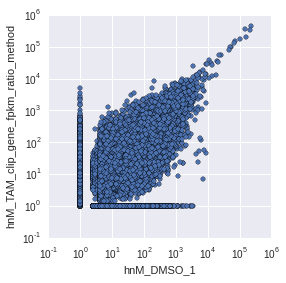

In [43]:
#plot a scatter plot of binding with the DMSO and ratio normalized TAM
#NOTE - what is this subset with high DMSO binding but low TAM binding? What clusters are these?
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_clip_gene_fpkm_ratio_method',figsize=(4,4),loglog=True)

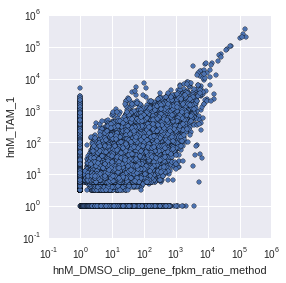

In [45]:
#plot a scatter plot of binding with ratio normalized DMSO and TAM
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_clip_gene_fpkm_ratio_method',y='hnM_TAM_1',figsize=(4,4),loglog=True)

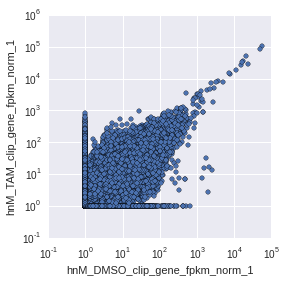

In [46]:
#plot a scatter plot of FPKM gene norm

ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_clip_gene_fpkm_norm_1',y='hnM_TAM_clip_gene_fpkm_norm_1',figsize=(4,4),loglog=True)

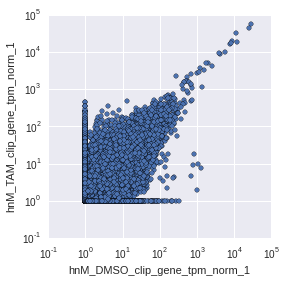

In [26]:
#plot a scatter plot of TPM gene norm
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_clip_gene_tpm_norm_1',y='hnM_TAM_clip_gene_tpm_norm_1',figsize=(4,4),loglog=True)

('Total Number of Clusters', 392095)
('Mes Bound Clusters', 76394)
('Epi Bound Clusters', 48412)
('Unchanged Clusters', 267289)


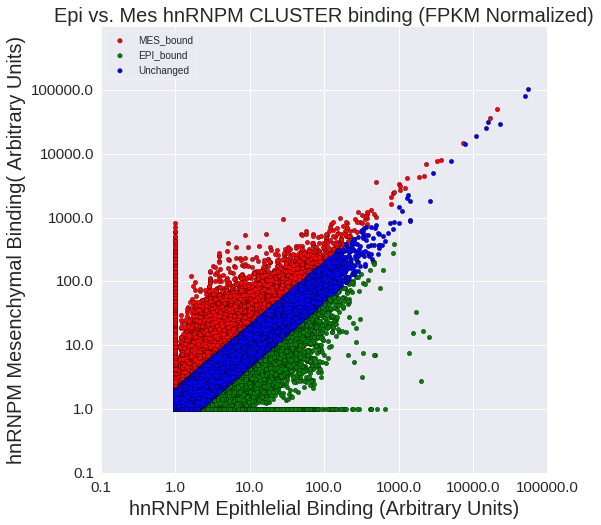

In [17]:
#We are plotting the clusters here
#try to make a prettier figure with colors
#get a dataframe with log2ratio_hnM_TAM_DMSO_gene_norm > or < 1

#Remember that the below 3 lines are condition (True False columns that can then be applied to the dataframe)
tam_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= 1
dmso_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -1
non_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= 1

subset_tam = merge_df_high_genes[tam_bound]
subset_dmso = merge_df_high_genes[dmso_bound]
subset_non = merge_df_high_genes[non_bound]

fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM CLUSTER binding (FPKM Normalized)",fontsize='20',)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom = 10e-2)
ax.set_xlim(left = 10e-2)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
ax.set_xticklabels(ticks,fontsize='15',)
ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_CLUSTER_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Clusters',len(merge_df_high_genes))
print('Mes Bound Clusters',len(subset_tam))
print('Epi Bound Clusters',len(subset_dmso))
print('Unchanged Clusters',len(subset_non))

# #Plotting an identity line
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)

count    392095.000000
mean         47.796289
std          40.171379
min           1.000000
25%          30.000000
50%          31.000000
75%          52.000000
max         824.000000
dtype: float64

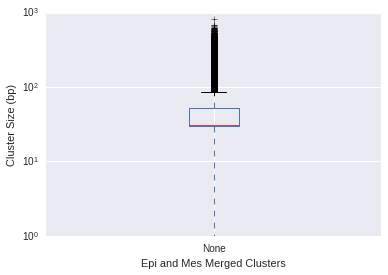

In [18]:
#Plot a boxplot of the cluster sizes
#Why don't the outliers show up? 824 size cluster is not showing
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
ax = cluster_size.plot.box(showfliers=True)
ax.set_ylabel('Cluster Size (bp)')
ax.set_xlabel('Epi and Mes Merged Clusters')
ax.set_yscale('log')
fig = ax.get_figure()
fig.savefig('epi_vs_mes_hnM_CLUSTER_binding_fpkm_normalized_boxplot',format='png',dpi=300)
cluster_size.describe()

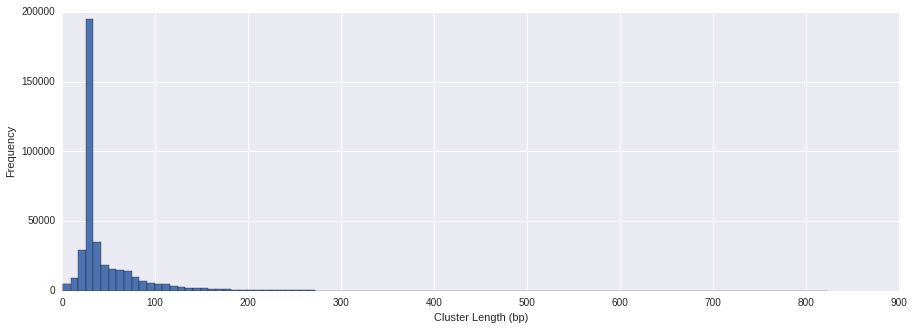

In [48]:
#PLOT A HISTOGRAM OF THE CLUSTER SIZES
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
ax = cluster_size.hist(bins=100,figsize=(15,5))
ax.set_xlabel('Cluster Length (bp)')
ax.set_ylabel('Frequency')
ax.set_yscale('linear')


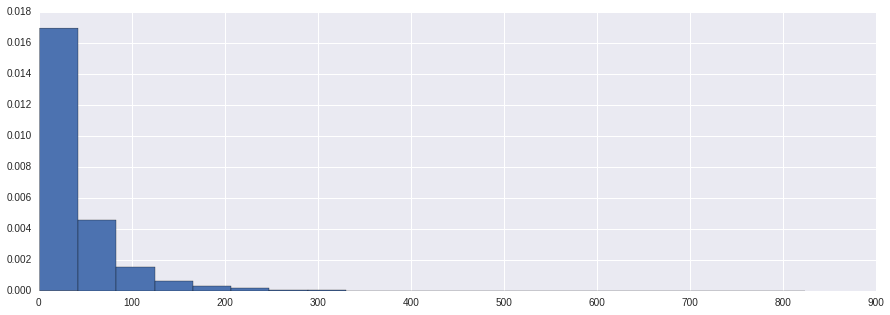

In [49]:
#PLOT A HISTOGRAM WITH PERCENTAGE ON THE Y AXIS
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
count = cluster_size.count()
cluster_size.hist(bins=20,figsize=(15,5),normed=True)

x = np.random.randn(30)

#Instructions below for how to get a histogram that sums to 1:

# fig, ax = plt.subplots(1,2, figsize=(10,4))

# ax[0].hist(x, normed=True, color='grey')

# hist, bins = np.histogram(x)
# ax[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='grey')

# ax[0].set_title('normed=True')
# ax[1].set_title('hist = hist / hist.sum()')

In [50]:
#How can you bin with your own bins in pandas --> pd.cut()

/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


('Total Number of Clusters', 8174)
('Mes Bound Clusters', 1593)
('Epi Bound Clusters', 1561)
('Unchanged Clusters', 5020)


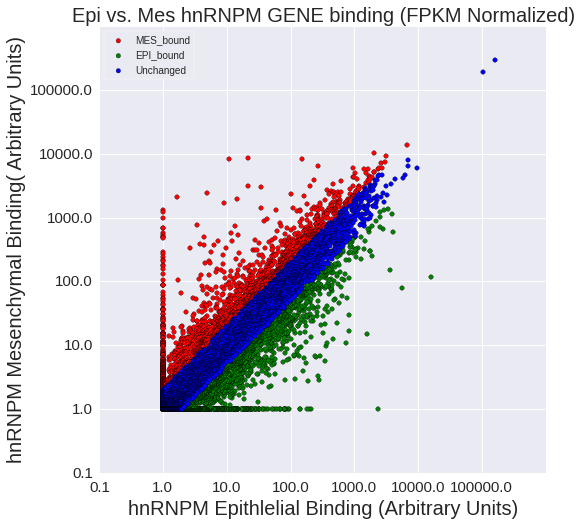

In [51]:
#GROUPBY WITH GENES
#Here we figure out how to obtain the genes with their expression normalized change in binding - this is the key dataset

#groupby = the split,apply,combine strategy for data analysis
#Here I will obtain the sums by FPKM for the expressed genes after normalization   
#also make sure you keep the FPKM for the gene as wells
gene_group = merge_df_high_genes.groupby('ens_gene')
hnM_DMSO_clip_gene_fpkm_norm_counts = gene_group.hnM_DMSO_clip_gene_fpkm_norm.aggregate(np.sum)
hnM_TAM_clip_gene_fpkm_norm_counts = gene_group.hnM_TAM_clip_gene_fpkm_norm.aggregate(np.sum)
twist_d0_fpkm_1 = gene_group.twist_d0_fpkm_1.aggregate(np.mean)
twist_d14_fpkm_1 = gene_group.twist_d14_fpkm_1.aggregate(np.mean)
log2ratio_fpkm_d14_d0 = gene_group.log2ratio_fpkm_d14_d0.aggregate(np.mean)


#put these counts into a dataframe so you can calculate the log2 ratio

gene_fpkm_norm_counts = pd.concat([hnM_DMSO_clip_gene_fpkm_norm_counts, hnM_TAM_clip_gene_fpkm_norm_counts,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0], axis=1).reset_index()

#add some pseudocount columns for plotting
#This is the key pseudocount to make sure you include highly expressed genes that have a very low pseudocount value
pseudocount = 1
gene_fpkm_norm_counts['hnM_DMSO_clip_gene_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_DMSO_clip_gene_fpkm_norm']+pseudocount,axis=1)
gene_fpkm_norm_counts['hnM_TAM_clip_gene_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_TAM_clip_gene_fpkm_norm']+pseudocount,axis=1)

#Calculate log2 ratio,make sure to add 1 in case genes have no value
gene_fpkm_norm_counts['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm']+pseudocount,2)-log(row['hnM_DMSO_clip_gene_fpkm_norm']+pseudocount,2)),axis=1)

#add in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
gene_fpkm_norm_counts_and_names = pd.merge(gene_fpkm_norm_counts,gene_name_and_biotype_df,on='ens_gene',how='left')

#Now split this gene_fpkm_norm_counts by log2fold change in binding and save in the GO folder

tam_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= 1
dmso_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -1
non_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= 1

subset_tam = gene_fpkm_norm_counts_and_names[tam_bound]
subset_tam.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)
subset_dmso = gene_fpkm_norm_counts_and_names[dmso_bound]
subset_dmso.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=True,inplace=True,axis=0)
subset_non = gene_fpkm_norm_counts_and_names[non_bound]
subset_non.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)

subset_tam.to_csv('GO_analysis/tam_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_tam.ens_gene.to_csv('GO_analysis/tam_bound_genes_ensg_only.txt',index=False)
subset_dmso.to_csv('GO_analysis/dmso_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_dmso.ens_gene.to_csv('GO_analysis/dmso_bound_genes_ensg_only.txt',index=False)
subset_non.to_csv('GO_analysis/non_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_non.ens_gene.to_csv('GO_analysis/non_bound_genes_ensg_only.txt',index=False)

#also need the background gene list of genes expressed in each cell type
epi_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d0_fpkm >= 5]
epi_expressed_genes = epi_expressed_df[['ens_gene','gene']]
epi_expressed_genes.ens_gene.to_csv('GO_analysis/epi_expressed_genes_ensg_only.txt',index=False)
mes_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d14_fpkm >= 5]
mes_expressed_genes = mes_expressed_df[['ens_gene','gene']]
mes_expressed_genes.ens_gene.to_csv('GO_analysis/mes_expressed_genes_ensg_only.txt',index=False)

#plot the genes as well
fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM GENE binding (FPKM Normalized)",fontsize='20',)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom = 10e-2)
ax.set_xlim(left = 10e-2)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
ax.set_xticklabels(ticks,fontsize='15',)
ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_GENE_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Clusters',len(gene_fpkm_norm_counts_and_names))
print('Mes Bound Clusters',len(subset_tam))
print('Epi Bound Clusters',len(subset_dmso))
print('Unchanged Clusters',len(subset_non))


In [ ]:
#Think of the best way to show relationship between binding and gene expression
#Just a scatter plot for each gene with binding and gene expression
#What about differential binding and gene expression - how to relate this in a plot

In [22]:
subset_tam.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,104.855841,366.333329,11.882057,10.114604,-0.364563,105.855841,367.333329,2.001392
std,325.417666,987.622411,22.089028,37.866639,1.286162,325.417666,987.622411,1.297669
min,0.000000,1.007890,1.000000,1.138400,-3.379264,1.000000,2.007890,1.000147
25%,1.126288,9.498875,3.287940,2.603890,-1.186594,2.126288,10.498875,1.259275
50%,10.164803,48.251574,6.106810,4.351980,-0.692286,11.164803,49.251574,1.580185
75%,69.788509,257.974979,12.407000,8.636320,0.110558,70.788509,258.974979,2.184294
max,6732.691192,13930.268383,484.235000,1245.620000,7.037389,6733.691192,13931.268383,10.369786


In [68]:
non_zero = subset_tam[subset_tam.hnM_DMSO_clip_gene_fpkm_norm != 0]

In [69]:
non_zero.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000
mean,126.541936,433.323587,13.436812,10.136567,-0.603729,127.541936,434.323587,1.827850
std,353.650018,1070.547585,23.883199,40.201287,1.043336,353.650018,1070.547585,0.994738
min,0.098690,1.423941,1.013860,1.186490,-3.379264,1.098690,2.423941,1.000147
25%,3.819363,16.662701,3.920455,2.596597,-1.245640,4.819363,17.662701,1.232120
50%,19.788704,76.913854,7.248230,4.380300,-0.816728,20.788704,77.913854,1.525524
75%,92.572468,344.597329,14.093625,8.768920,-0.184820,93.572468,345.597329,2.063590
max,6732.691192,13930.268383,484.235000,1245.620000,5.476372,6733.691192,13931.268383,10.282389


In [52]:
gene_fpkm_norm_counts_and_names.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000
mean,134.432829,203.269079,54.919327,63.167308,-0.138162,135.432829,204.269079,-0.012233
std,2162.195042,3970.210176,296.380356,355.783544,1.119934,2162.195042,3970.210176,1.495635
min,0.000000,0.000000,1.000000,1.000000,-6.460721,1.000000,1.000000,-11.184618
25%,0.937343,0.578446,5.196365,3.836195,-0.858144,1.937343,1.578446,-0.734324
50%,7.561395,6.915624,11.528200,9.685720,-0.196352,8.561395,7.915624,-0.060215
75%,58.194930,61.860004,29.408225,31.546825,0.551079,59.194930,62.860004,0.732526
max,162106.854228,296903.753879,9037.280000,11001.600000,8.790504,162107.854228,296904.753879,10.369786


In [65]:
non_zero = gene_fpkm_norm_counts_and_names[gene_fpkm_norm_counts_and_names.hnM_TAM_clip_gene_fpkm_norm != 0]

In [66]:
non_zero.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000,7072.000000
mean,154.453046,234.943645,46.715240,57.804020,-0.097021,155.453046,235.943645,0.161652
std,2323.772791,4267.515459,237.503612,334.627338,1.083330,2323.772791,4267.515459,1.441240
min,0.000000,0.000651,1.000000,1.033011,-5.239634,1.000000,1.000651,-7.080125
25%,1.794427,1.861225,5.163623,3.916288,-0.833755,2.794427,2.861225,-0.600655
50%,12.324138,12.692887,11.192250,9.616430,-0.189581,13.324138,13.692887,0.079889
75%,74.316940,84.405448,27.843875,30.491625,0.558562,75.316940,85.405448,0.895402
max,162106.854228,296903.753879,9037.280000,11001.600000,8.790504,162107.854228,296904.753879,10.369786


In [54]:
sort_df = non_zero.sort(columns='hnM_DMSO_clip_gene_fpkm_norm',ascending=True)

/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [55]:
sort_df.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000
mean,143.641039,215.667934,56.253116,62.326400,-0.209899,144.641039,216.667934,-0.126668
std,2234.733681,4103.547621,300.470861,351.060192,1.045057,2234.733681,4103.547621,1.389191
min,0.000887,0.000000,1.000000,1.000000,-6.460721,1.000887,1.000000,-11.184618
25%,1.453631,0.667069,5.485067,3.825165,-0.890524,2.453631,1.667069,-0.800608
50%,9.970641,8.554784,11.882850,9.651260,-0.247972,10.970641,9.554784,-0.127913
75%,66.241049,70.345672,30.261025,31.227025,0.481085,67.241049,71.345672,0.623134
max,162106.854228,296903.753879,9037.280000,11001.600000,8.790504,162107.854228,296904.753879,10.282389


In [31]:
less_than_1 = sort_df[sort_df.hnM_DMSO_clip_gene_fpkm_norm < 1]

In [38]:
a = less_than_1.sort(columns='twist_d0_fpkm_1',ascending=False)

/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


('Total Number of Genes', 8174)
('Mes Bound Genes', 492)
('Epi Bound Genes', 516)
('Unchanged Genes', 7166)


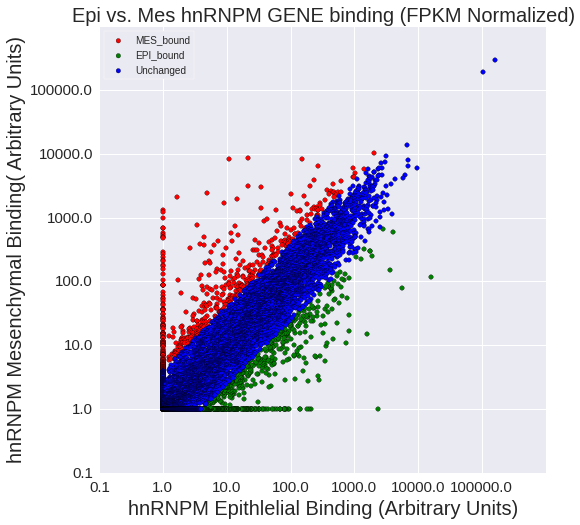

In [31]:
#Differential Binding Cutoff Tuning
#Use this to tune the results based on output
#Set the cutoff here
cutoff = 2
tam_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= cutoff
dmso_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -cutoff
non_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= cutoff

subset_tam = gene_fpkm_norm_counts_and_names[tam_bound]
subset_tam.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)
subset_dmso = gene_fpkm_norm_counts_and_names[dmso_bound]
subset_dmso.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=True,inplace=True,axis=0)
subset_non = gene_fpkm_norm_counts_and_names[non_bound]
subset_non.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)

subset_tam.to_csv('GO_analysis/tam_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_tam.ens_gene.to_csv('GO_analysis/tam_bound_genes_ensg_only.txt',index=False)
subset_dmso.to_csv('GO_analysis/dmso_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_dmso.ens_gene.to_csv('GO_analysis/dmso_bound_genes_ensg_only.txt',index=False)
subset_non.to_csv('GO_analysis/non_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_non.ens_gene.to_csv('GO_analysis/non_bound_genes_ensg_only.txt',index=False)

#also need the background gene list of genes expressed in each cell type
epi_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d0_fpkm >= 5]
epi_expressed_genes = epi_expressed_df[['ens_gene','gene']]
epi_expressed_genes.ens_gene.to_csv('GO_analysis/epi_expressed_genes_ensg_only.txt',index=False)
mes_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d14_fpkm >= 5]
mes_expressed_genes = mes_expressed_df[['ens_gene','gene']]
mes_expressed_genes.ens_gene.to_csv('GO_analysis/mes_expressed_genes_ensg_only.txt',index=False)

#plot the genes as well
fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM GENE binding (FPKM Normalized)",fontsize='20',)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom = 10e-2)
ax.set_xlim(left = 10e-2)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
ax.set_xticklabels(ticks,fontsize='15',)
ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_GENE_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Genes',len(gene_fpkm_norm_counts_and_names))
print('Mes Bound Genes',len(subset_tam))
print('Epi Bound Genes',len(subset_dmso))
print('Unchanged Genes',len(subset_non))


In [246]:
#counts of these various sets
print(len(subset_dmso))
print(len(subset_tam))
print(len(subset_non))

174
291
5471


In [43]:
#Find the tamoxifen only bound genes in my mega cluster - why aren't they showing up in my normalized set
#They weren't showing up because of expression cutoffs, etc.
#Want to see if normalization is making a difference
location = '/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/gene_ontology_analysis/2016_06_analysis_using_2016_03_iclip/web_gestalt_analysis/'
ryan_tam_exclusive_biological_adhesion_df = pd.read_csv(location+'tam_proteincoding_exclusive_biological_adhesion_sorted',names=['ens_gene'])

#don't just look at the high genes, look at all

gene_group = merge_df.groupby('ens_gene')
hnM_DMSO_clip_gene_fpkm_norm_counts = gene_group.hnM_DMSO_clip_gene_fpkm_norm.aggregate(np.sum)
hnM_TAM_clip_gene_fpkm_norm_counts = gene_group.hnM_TAM_clip_gene_fpkm_norm.aggregate(np.sum)
twist_d0_fpkm_1 = gene_group.twist_d0_fpkm_1.aggregate(np.mean)
twist_d14_fpkm_1 = gene_group.twist_d14_fpkm_1.aggregate(np.mean)
log2ratio_fpkm_d14_d0 = gene_group.log2ratio_fpkm_d14_d0.aggregate(np.mean)


#put these counts into a dataframe so you can calculate the log2 ratio
gene_fpkm_norm_counts = pd.concat([hnM_DMSO_clip_gene_fpkm_norm_counts, hnM_TAM_clip_gene_fpkm_norm_counts,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0], axis=1).reset_index()
gene_fpkm_norm_counts['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm'],2)-log(row['hnM_DMSO_clip_gene_fpkm_norm'],2)),axis=1)

#add in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
gene_fpkm_norm_counts_and_names = pd.merge(gene_fpkm_norm_counts,gene_name_and_biotype_df,on='ens_gene',how='left')

#merge_based on this and the merge_df_high_genes
ryan_biological_adhesion_result = pd.merge(ryan_tam_exclusive_biological_adhesion_df,gene_fpkm_norm_counts_and_names,on='ens_gene',how='left')

In [198]:
#this is how to figure out how many of the different biotypes are represented
gene_fpkm_norm_counts_and_names.groupby('biotype').count()

,ens_gene,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,external_gene_name
biotype,,,,,,,,,,
3prime_overlapping_ncRNA,2,2,2,2,2,2,2,2,2,2
antisense,86,86,86,86,86,86,86,86,86,86
lincRNA,77,77,77,77,77,77,77,77,77,77
processed_pseudogene,22,22,22,22,22,22,22,22,22,22
processed_transcript,42,42,42,42,42,42,42,42,42,42
protein_coding,7755,7755,7755,7755,7755,7755,7755,7755,7755,7755
sense_intronic,3,3,3,3,3,3,3,3,3,3
sense_overlapping,8,8,8,8,8,8,8,8,8,8
snRNA,6,6,6,6,6,6,6,6,6,6


In [175]:
#function to get the unique values
def get_uniq(gene_list):
    counter=0
    for item in gene_list:
        uniq = item['ens_gene'].unique()
        uniq_list = uniq.tolist()
        name_list = ['tam_genes','dmso_genes','non_genes']
        with open('GO_analysis/'+name_list[counter]+'_uniq','w') as f:
            writer = csv.writer(f,'textdialect')
            writer.writerows(uniq_list)
        counter+=1

In [152]:
#This is how you find rows associated with a specific column in a dataframe
#Try to remember this
twist_gene_exp_df.loc[twist_gene_exp_df['ens_gene'] == 'ENSG00000229807']
merge_df_high_genes.loc[merge_df_high_genes['ens_gene'] == 'ENSG00000229807']

,chrom,start,end,ens_gene,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,...,log2ratio_fpkm_d14_d0,twist_d0_tpm_1,twist_d14_tpm_1,log2ratio_tpm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm
398809,chrX,73046334,73046407,ENSG00000229807,-,71.879589,61.741219,72.879589,62.741219,-0.216101,...,-0.034147,9.808075,8.087942,-0.278197,12.952222,11.512293,8.328613,8.633737,-0.170024,0.051909
398810,chrX,73070168,73070335,ENSG00000229807,-,5222.343580,14708.702070,5223.343580,14709.702070,1.493723,...,-0.034147,9.808075,8.087942,-0.278197,869.377408,2505.359105,533.453455,1819.596412,1.526963,1.770184
398811,chrX,73070366,73070479,ENSG00000229807,-,707.916822,2658.302485,708.916822,2659.302485,1.907360,...,-0.034147,9.808075,8.087942,-0.278197,118.713238,453.612610,73.176936,329.674776,1.933980,2.171583
398812,chrX,73070706,73070853,ENSG00000229807,-,4691.211694,12608.928950,4692.211694,12609.928950,1.426220,...,-0.034147,9.808075,8.087942,-0.278197,781.060176,2147.843812,479.300946,1559.978681,1.459383,1.702523
398813,chrX,73070983,73070997,ENSG00000229807,-,0.000000,824.359609,1.000000,825.359609,9.688879,...,-0.034147,9.808075,8.087942,-0.278197,1.000000,141.358577,1.000000,102.924522,7.143216,6.685443
398814,chrX,73071035,73071178,ENSG00000229807,-,8501.995552,10565.751940,8502.995552,10566.751940,0.313489,...,-0.034147,9.808075,8.087942,-0.278197,1414.721780,1799.964786,867.836284,1307.358541,0.347450,0.591160
398815,chrX,73071221,73071410,ENSG00000229807,-,8021.762187,13452.725610,8022.762187,13453.725610,0.745835,...,-0.034147,9.808075,8.087942,-0.278197,1334.868014,2291.511815,818.873226,1664.306416,0.779603,1.023209
398816,chrX,73071422,73071697,ENSG00000229807,-,13273.634680,26939.751890,13274.634680,26940.751890,1.021118,...,-0.034147,9.808075,8.087942,-0.278197,2208.155524,4587.863791,1354.337354,3331.853796,1.054981,1.298738


In [ ]:
#BUFFER BUFFER BUFFER BUFFER

#NOTE - THIS IS NOT THE BEST WAY TO WORK ON THIS... BETTER TO DO AN EXON CENTRIC OR SPLICING EVENT CENTRIC ANALYSIS

#NOW FIGURE OUT HOW TO BRING IN THE ALTERNATIVE EXONS
#put this in the directory spliced_exon_analysis

#Goal - associate the clusters with nearest exon using bedtools closest

#Ideal setup - have each cluster associated with nearest 1 exon. This exon must be able to be labeled as constitutive vs. alternative. This exon must then be able to be associated with a PSI value from each of our RNA seq analyses... How can I do this? Many of the splicing events will not match exactly.

#Associate clusters with all exons first. Mark whether the exon is constitutive or variable.

#HOW CAN I KNOW WHETHER AN EXON IS CONSTITUTIVE OR ALTERNATIVE?
#WHY NOT USE RMATS FOR TWIST-ER CELLS? All SE called by rMATS will be merged and take the longest one. If an exon overlaps with this list, it is alternative. If it does not, it is constitutive
#Caveat with this - We don't want false positives. maxPSI > 15%, minPSI < 85% ensures we don't take all skipped or all included exons.
#Another source of information - MISO splicing library
#Another source = hg19 knownAlt
#If the exon is going to be paired with a PSI value it must be alternative

#Then associate clusters with alternative exons from rMATS. Presumably rMATS exons are all alternatively spliced and contain no constitutively spliced exons. Can separate significantly differentially spliced from control using Carsten's publication "control alternative" cutoff (FDR > 50%, maxPSI of > 15%, minPSI < 85%)

#As an exon annotation, I am using the hg19_v19 exons from CLIPPER, this is also copied in this directory
#Other exon annotations that are available:
#FAST-iCLIP-docs = hg19_transcriptome_collapse_exon.bed
#Extract transcript regions script
hg19_v19_exons = pd.read_csv('spliced_exon_analysis/hg19_v19_exons.bed',sep='\t',names=['chrom','start','stop','ens_gene','blank','strand'])
hg19_v19_exons['ens_gene']=hg19_v19_exons.ens_gene.str.split('.').str[0]
#read in gene names and biotypes
#I got this from ensembl biomart using the last GRCh37 archive - ENS version 75
hg19_grch37_gene_names_and_biotype = pd.read_csv('spliced_exon_analysis/ensembl_ens_gene_gene_name_biotype_grch37_p13',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#why are there duplicates?
hg19_grch37_gene_names_and_biotype.drop_duplicates(inplace=True)

#merge the exons with the gene names and biotypes
hg19_v19_exons = pd.merge(hg19_v19_exons,hg19_grch37_gene_names_and_biotype,on='ens_gene',how='left')
hg19_v19_exons.to_csv('spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes',sep='\t',header=False,index=False,na_rep='NaN')

#save a copy of the merge_df clusters as a bedtools
cluster_column_list = ['chrom','start','end','ens_gene','cluster_id','strand']
merge_df.to_csv('spliced_exon_analysis/merge_df.bed',sep='\t',na_rep='NaN',columns=cluster_column_list,header=False,index=False)

#run closest bed with exons and keep the distance as a column
#handle ties by taking both items
#This means that some of the clusters will be associated with multiple exons
!bedtools closest -a spliced_exon_analysis/merge_df.bed -b spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes -D "ref" -s -t "all" > spliced_exon_analysis/merge_df_closest_exons

!bedtools closest -a spliced_exon_analysis/merge_df.bed -b spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes -D "ref" -s -t "first" > spliced_exon_analysis/merge_df_closest_exons_first_ties

#bring in the data from TwistER, CC, and HH rMATS into splicing analysis folder
#I used parse_rMATS_SE -fdr 0.05 -psi 0.1 -read 20
#NOTE - it may be better for me in the future to just read in the data and parse it myself however I'd like - do this later

#Should I do bedtools closest on each cluster next to an exon from CC, HH, TwistER? Set a limit of maximal distance

#bring in the data from TwistER, CC, and HH rMATS into splicing analysis folder
#I used parse_rMATS_SE -fdr 0.05 -psi 0.1 -read 20
#NOTE - it may be better for me in the future to just read in the data and parse it myself however I'd like - do this later
#Should I do bedtools closest on each cluster next to an exon from CC, HH, TwistER? Set a limit of maximal distance
cc1_cc2_rMATS_df = pd.read_csv('spliced_exon_analysis/CC-1_CC-2_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
cc3_cc4_rMATS_df = pd.read_csv('spliced_exon_analysis/CC-3_CC-4_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
hh5_hh6_rMATS_df = pd.read_csv('spliced_exon_analysis/HH-5_HH-6_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
twist_d0_d14_rMATS_df = pd.read_csv('spliced_exon_analysis/SEH-1_SEH-2_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')

#Now that I have this, I want to do bedtools closest to see if this this good

In [ ]:
#BUFFER BUFFER BUFFER BUFFER BUFFER BUFFER BUFFER

In [23]:
#BD merge adjancent clip clusters and remove duplicates
#Just use his script for now
#The reason there are duplicates are that there are some overlapping genes that are counted twice if they are on the same strand.
# added by BD 4/12/15 to merge adjacent clip clusters and remove duplicates
CLIPPERout_dup = 'hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl'
CLIPPERout = CLIPPERout_dup.replace('binomial_dupl','binomial_final') 
with open(CLIPPERout_dup,'r') as ifile, open(CLIPPERout,'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    currRow = ['chr1',0,0,0,0,'+']
    for row in reader:
        currStart = int(currRow[1])
        currEnd = int(currRow[2])
        newStart = int(row[1])
        newEnd = int(row[2])
        if currStart==newStart and currEnd==newEnd: continue #duplicates
        if math.fabs(newStart-currEnd) <= 15 and currRow[5]==row[5]: #overlap and same strand
            if int(currRow[1]) != 0: #not the first one
                currRow[2]=newEnd #merge the two adjacent clusters
        else: #not overlap
            if int(currRow[1]) != 0:
                writer.writerow(currRow)
            currRow = row #cycle continues
    writer.writerow(currRow) #fencepost

In [13]:
#Now do the part where we process the clipper output and isolate lowFDR reads based on clipper windows
def modCLIPPERout(CLIPPERin, CLIPPERout):
	# Usage: Process the CLIPper output and isolate lowFDR reads based upon CLIPper windows.
	# Input: .bed file passed into CLIPper and the CLIPper windows file.
	# Output: Low FDR reads recovered using the CLIPer windows file, genes per cluster, gene list of CLIPper clusters, and CLIPper windows as .bed.
	
	CLIPperOutBed = CLIPPERout + '.bed' # CLIPper windows as a bed file
	CLIPperReadsPerCluster = CLIPPERout + '.readsPerCluster' # Number of reads per CLIPper cluster
	CLIPperGeneList = CLIPPERout + '.geneNames' # Gene names returned from the CLIPper file
	CLIPPERlowFDR = CLIPperOutBed.replace('.bed','_lowFDRreads.bed') # Low FDR reads returned filtered through CLIPper windows
	
	with open(CLIPPERout,'r') as infile, open(CLIPperOutBed,'w') as f, open(CLIPperReadsPerCluster,'w') as g, open(CLIPperGeneList,'w') as h:
		for line in infile:	
			try:
				# *** Old CLIPper includes a header that cannot be parsed. Handle this. ***
				# *** Old CLIPper: Ensembl genes are parsed with <name>_<cluster>_<count>. ***
				chrom,start,end,name,stats,strand,start_2,end_2 = line.strip().split('\t')
				readPerCluster=name.strip().split('_')[2]
				geneName=name.strip().split('_')[0].split('.')[0]
				f.write('\t'.join((chrom,start,end,name,stats,strand))+'\n')
				g.write((readPerCluster+'\n'))
				h.write((geneName+'\n'))
			except:
				continue
				
	# Intersect input reads with the CLIPper windows and report full result for both.
	cmd = "bedtools intersect -a {} -b {} -wa -wb -s > {}".format(CLIPPERin, CLIPperOutBed, CLIPPERlowFDR)
	os.system(cmd)
	
	return (CLIPPERlowFDR, CLIPperReadsPerCluster, CLIPperGeneList, CLIPperOutBed)

In [27]:
#run it with DMSO
modCLIPPERout("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final")
#run it with TAM
modCLIPPERout("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final")

('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.readsPerCluster',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.geneNames',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.bed')

In [53]:
def getBedCenterPoints(inBed, expand, namecol):
	# Usage: Obtain center coordinates of bedFile.
	# Input: BedFile.	
	# Output: Center coordinates returned.
	outBed = inBed.replace('.bed','_centerCoord.bed')
	with open(inBed, 'r') as ifile, open(outBed, 'w') as ofile:
		reader = csv.reader(ifile, 'textdialect')
		writer = csv.writer(ofile, 'textdialect')
		for row in reader:
			writer.writerow([row[0], int(row[1]) + expand, int(row[1]) + expand + 1, row[namecol], row[4], row[5]])
    return outBed
def cleanBedFile(inBed):
	# Usage: Sort and recover only first 6 fields from a bed file.
	# Input: BedFile.
	# Output: Sorted bedFile with correct number of fields.
	sortedBed = inBed.replace('.bed','_cleaned_sorted.bed')	
	cmd = "cut -f1-6 {} | sort -k1,1 -k2,2n > {}".format(inBed, sortedBed)
	os.system(cmd)
	return sortedBed
def makeBedGraph(cleanBed,sizesFile):
	# Usage: From a bedFile, generate a plus and minus and total bedGraph and bigWig.
	# Input: BedFile.
	# Output: BedGraph file.
	for strand in ["", "+", "-"]:
		word = ""
		if strand == "+": word = "_plus"
		elif strand == "-": word = "_minus"
		outname = cleanBed.replace('.bed', '{}.bedgraph'.format(word))
		outname2 = cleanBed.replace('.bed', '{}.bw'.format(word))
		if strand == "":
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} > {}".format(cleanBed, sizesFile, outname)
		else:
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} -strand {} > {}".format(cleanBed, sizesFile, strand, outname)
		cmd2 = "/home/sam/bin/ucsc_tools/bedGraphToBigWig {} {} {}".format(outname, sizesFile, outname2)
		os.system(cmd1)
		os.system(cmd2)
	return cleanBed.replace('.bed', '.bedgraph')


IndentationError: unindent does not match any outer indentation level (<ipython-input-53-23e79462011a>, line 11)

In [57]:
#This is the protocol to generate bedgraphs and bigwigs
genomeFile="/home/sam/bin/FAST-iCLIP/docs/hg19/human.hg19.genome"
#DMSO
cleanBed = cleanBedFile('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)
#TAM
cleanBed = cleanBedFile('hnM_TAM_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)

In [59]:
#Collapse and count the centerCoord.bed to keep the gene information but still make it into a bedgraph like entity
#Note - this shows that there are gene overlaps from clipper
#DMSO
!uniq -c hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_uniq.bed

In [61]:
#Try a bedtools merge
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed -c 4,6 -o distinct > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_merged.bed